Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("data_original/Train")
data_dir_test = pathlib.Path('data_original/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

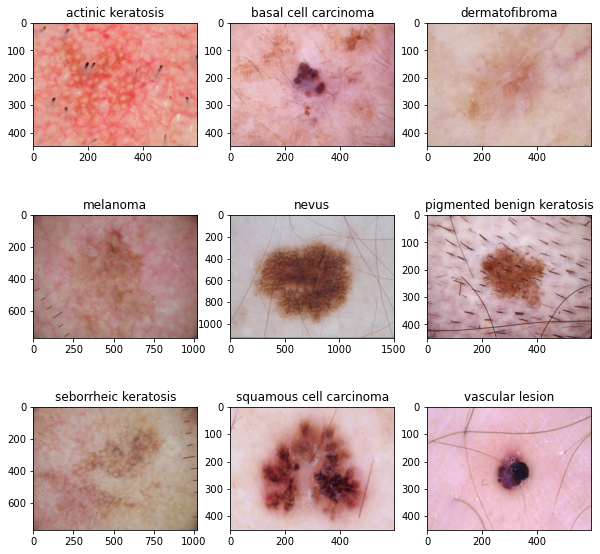

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 22s 316ms/step - loss: 2.0690 - accuracy: 0.2545 - val_loss: 1.8394 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 18s 318ms/step - loss: 1.6657 - accuracy: 0.4157 - val_loss: 1.6434 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 20s 352ms/step - loss: 1.4733 - accuracy: 0.4810 - val_loss: 1.3887 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 21s 373ms/step - loss: 1.3610 - accuracy: 0.5173 - val_loss: 1.3590 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 20s 355ms/step - loss: 1.2334 - accuracy: 0.5625 - val_loss: 1.4096 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 22s 388ms/step - loss: 1.1887 - accuracy: 0.5759 - val_loss: 1.3727 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 21s 375ms/step - loss: 1.1318 - accuracy: 0.6021 - val_loss: 1.3672 - val_accuracy: 0.5503

### Visualizing training results

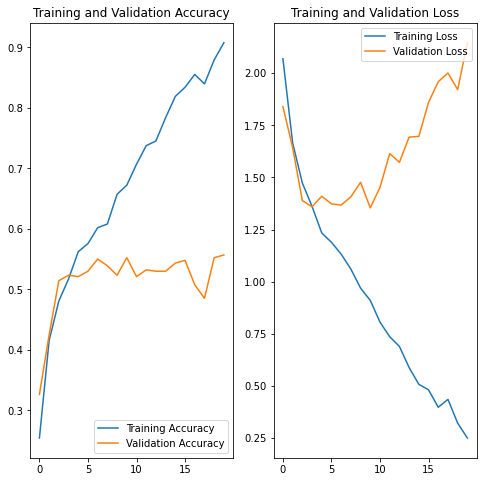

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

## Inferences 

- Training accuracy is observed to be around 90% whereas validation accuracy is around 56%. 
- The difference between training accuracy and validation accuracy is increasing gradually. Same is observed for loss function as well
- The validation accuracy is very low. Training accuracy is high.
- This shows the model is overfitting

Let us try augumenting the data

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

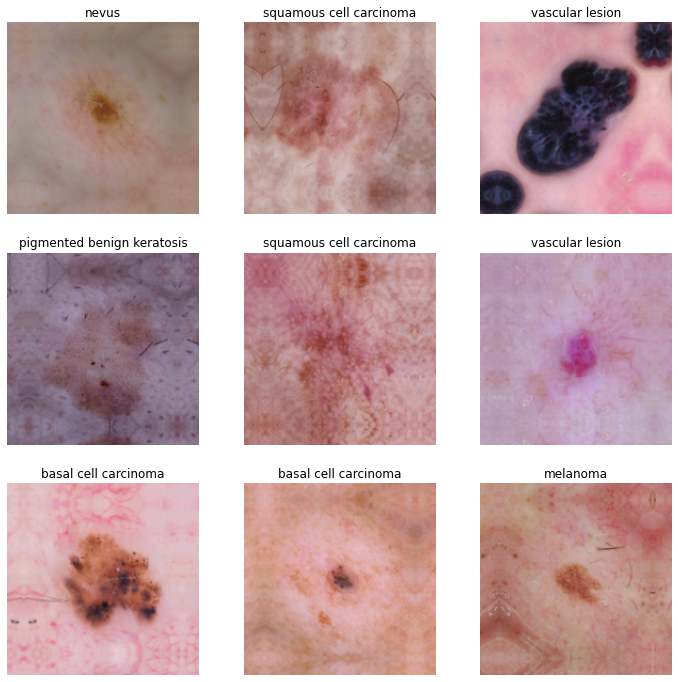

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

num_classes = len(class_names)

model = Sequential([
    data_augument,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 359ms/step - loss: 1.9555 - accuracy: 0.2757 - val_loss: 1.7389 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 20s 363ms/step - loss: 1.7870 - accuracy: 0.3733 - val_loss: 1.6339 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 22s 401ms/step - loss: 1.6614 - accuracy: 0.3778 - val_loss: 1.4732 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 26s 463ms/step - loss: 1.4556 - accuracy: 0.4933 - val_loss: 1.4463 - val_accuracy: 0.4966
Epoch 5/20
56/56 [==============================] - 25s 450ms/step - loss: 1.4109 - accuracy: 0.4994 - val_loss: 1.4597 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 23s 406ms/step - loss: 1.3885 - accuracy: 0.5151 - val_loss: 1.5896 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 23s 404ms/step - loss: 1.3968 - accuracy: 0.5089 - val_loss: 1.4668 - val_accuracy: 0.4899

### Visualizing the results

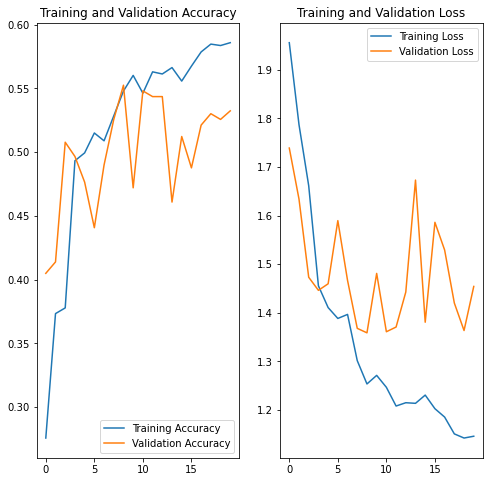

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Inferences 

- The accuracy of validation set is increased and the gap between training and validation set accuracy is reduced
- The underfitting issue is resolved after augmenting the data
- Overall the model accuracy is not increased much

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
1,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
2,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
3,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
4,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
...,...,...
2234,data_original/Train/vascular lesion/ISIC_00329...,vascular lesion
2235,data_original/Train/vascular lesion/ISIC_00330...,vascular lesion
2236,data_original/Train/vascular lesion/ISIC_00311...,vascular lesion
2237,data_original/Train/vascular lesion/ISIC_00308...,vascular lesion


In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
1,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
2,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
3,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
4,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
...,...,...
2234,data_original/Train/vascular lesion/ISIC_00329...,vascular lesion
2235,data_original/Train/vascular lesion/ISIC_00330...,vascular lesion
2236,data_original/Train/vascular lesion/ISIC_00311...,vascular lesion
2237,data_original/Train/vascular lesion/ISIC_00308...,vascular lesion


<BarContainer object of 9 artists>

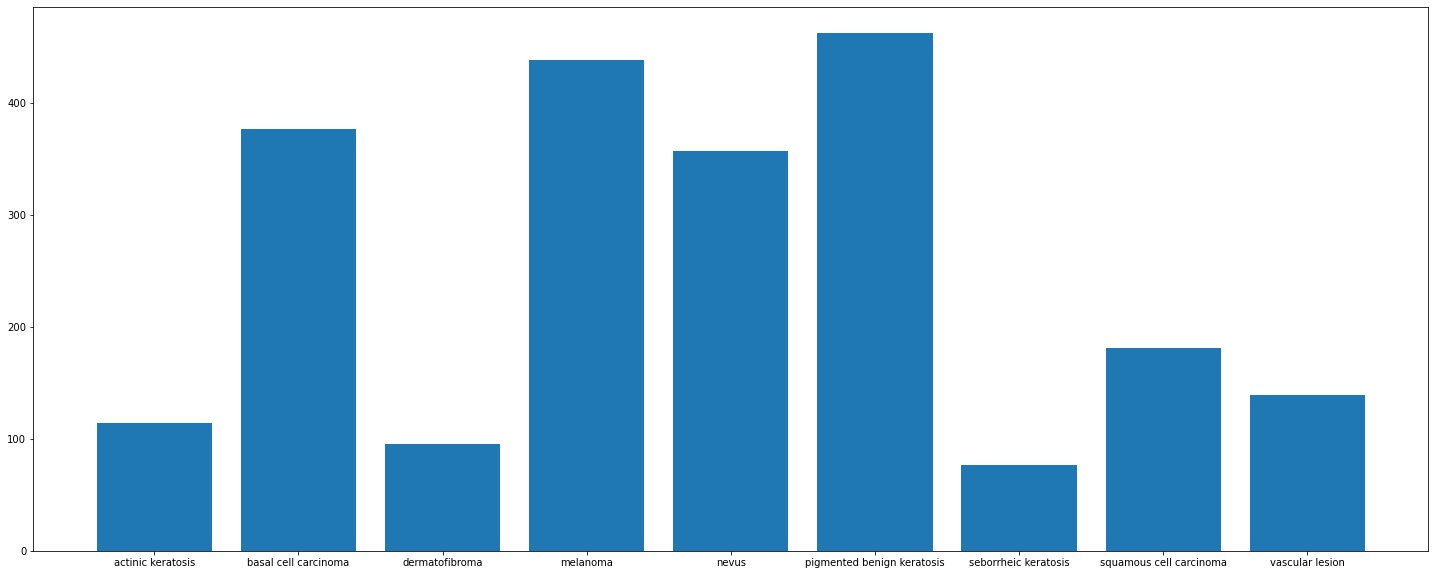

In [28]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- seborrheic keratosis class has the least number of samples

#### - Which classes dominate the data in terms proportionate number of samples?
- melanoma and pigmented benign keratosis dominate the data in terms of proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
path_to_training_dataset="data_original/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to data_original/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BAA0DA1F0>: 100%|██████████| 500/500 [00:02<00:00, 205.22 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to data_original/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D5D14D2E0>: 100%|██████████| 500/500 [00:02<00:00, 231.69 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to data_original/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BA9F8D970>: 100%|██████████| 500/500 [00:02<00:00, 232.58 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to data_original/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944 at 0x7F9CCA80F520>: 100%|██████████| 500/500 [00:13<00:00, 37.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to data_original/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F9BACE1DF10>: 100%|██████████| 500/500 [00:12<00:00, 40.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to data_original/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9BAA0DA910>: 100%|██████████| 500/500 [00:02<00:00, 203.32 Samples/s]


Initialised with 77 image(s) found.
Output directory set to data_original/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9BA9E32970>: 100%|██████████| 500/500 [00:06<00:00, 79.82 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to data_original/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9BA9E2A430>: 100%|██████████| 500/500 [00:02<00:00, 189.89 Samples/s]


Initialised with 139 image(s) found.
Output directory set to data_original/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BAC591AF0>: 100%|██████████| 500/500 [00:02<00:00, 196.96 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [35]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [36]:
##
for i in class_names:
      
    for j in data_dir_train.glob(i+'/output/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
1,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
2,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
3,data_original/Train/actinic keratosis/ISIC_002...,actinic keratosis
4,data_original/Train/actinic keratosis/ISIC_003...,actinic keratosis
...,...,...
6734,data_original/Train/vascular lesion/output/vas...,vascular lesion
6735,data_original/Train/vascular lesion/output/vas...,vascular lesion
6736,data_original/Train/vascular lesion/output/vas...,vascular lesion
6737,data_original/Train/vascular lesion/output/vas...,vascular lesion


In [37]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [41]:
## your code goes here
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)       

#### **Todo:**  Train your model

In [44]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 67s 389ms/step - loss: 1.7779 - accuracy: 0.3353 - val_loss: 1.5519 - val_accuracy: 0.4180
Epoch 2/50
169/169 [==============================] - 100s 586ms/step - loss: 1.3100 - accuracy: 0.5076 - val_loss: 1.2889 - val_accuracy: 0.5316
Epoch 3/50
169/169 [==============================] - 78s 459ms/step - loss: 1.0893 - accuracy: 0.5957 - val_loss: 1.0746 - val_accuracy: 0.6147
Epoch 4/50
169/169 [==============================] - 82s 478ms/step - loss: 0.9286 - accuracy: 0.6656 - val_loss: 0.9736 - val_accuracy: 0.6644
Epoch 5/50
169/169 [==============================] - 77s 453ms/step - loss: 0.6851 - accuracy: 0.7517 - val_loss: 0.9223 - val_accuracy: 0.7023
Epoch 6/50
169/169 [==============================] - 81s 474ms/step - loss: 0.5438 - accuracy: 0.8043 - val_loss: 0.7903 - val_accuracy: 0.7298
Epoch 7/50
169/169 [==============================] - 82s 483ms/step - loss: 0.4374 - accuracy: 0.8474 - val_loss: 0.7137 - val_a

#### **Todo:**  Visualize the model results

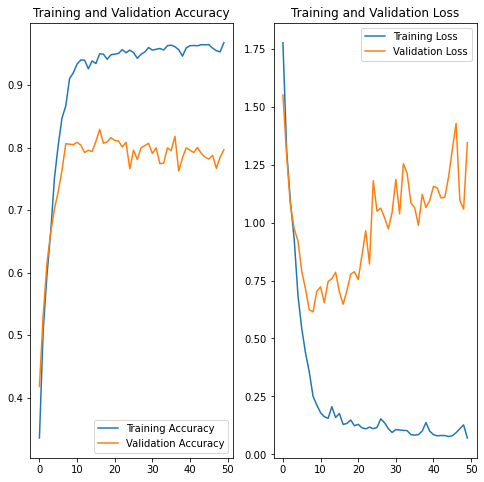

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- We can see an interesting trend when epoch is increased to a high value around 50. The training accuracy is increasing gradually but the validation accuracy is nearly static with increasing epochs.
- The gap of validation and train accuracy is increasing with epoch more than 10. Similar trend is there for loss function as well
- Below 10 epochs, overfitting/underfitting was not there. As the number of epocs are increased above 20 overfitting was observed
- Sufficiently good accuracy is observed after increasing epochs and class rebalancing